In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('mpg')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train)
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train)

initial loss:  852.2874755859375
final loss:  2.3082005977630615
initial loss:  845.658935546875
final loss:  2.4076626300811768
initial loss:  742.704345703125
final loss:  2.331528902053833
initial loss:  1012.1467895507812
final loss:  2.340217113494873
initial loss:  823.4892578125
final loss:  2.2657511234283447
final loss:  2.681199789047241


Deep ensemble test MAPE:  0.0826485
Deep ensemble test RMSE:  2.6183038
Deep ensemble test NLLK:  2.6651287
Deep ensemble test CRPS:  tensor(1.3508)


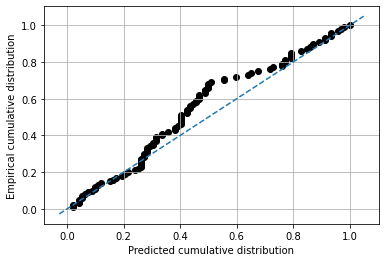

Deep ensemble test calibration error when step size is 0.001:  5.651354442344045
Deep ensemble test calibration error when step size is 0.01:  0.5598913043478263
Deep ensemble test calibration error when step size is 0.1:  0.05534026465028356


In [4]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.93it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 12.08it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.924
  RMSE          2.618
  MDAE          1.472
  MARPD         8.247
  R2            0.879
  Correlation   0.939
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.070
  Mean-absolute Calibration Error       0.057
  Miscalibration Area                   0.057
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.177
     Group Size: 0.56 -- Calibration Error: 0.090
     Group Size: 1.00 -- Calibration Error: 0.057
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.222
     Group Size: 0.56 -- Calibration Error: 0.109
     Group Size: 1.00 -- Calibration Error: 0.070
================

Lims is None. Setting lims now:
min_max_true: (11.0, 46.6)
min_max_pred: (12.41355, 44.95321)
lims: (11.0, 46.6)
lims_ext: (7.44000015258789, 50.1599983215332)


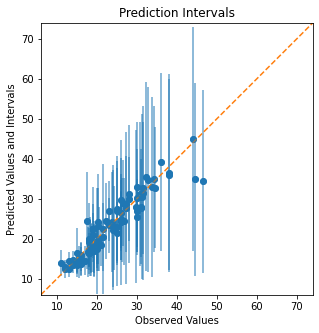

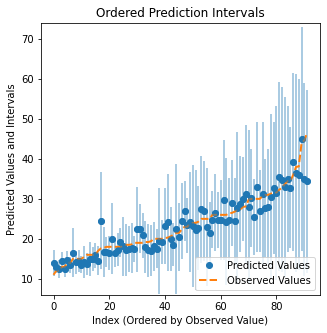

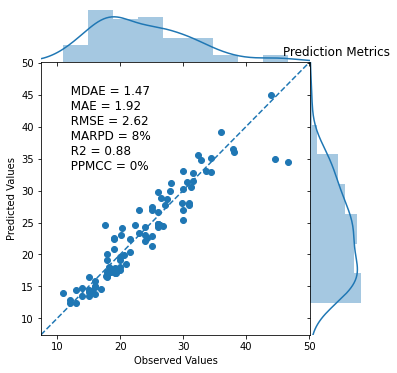

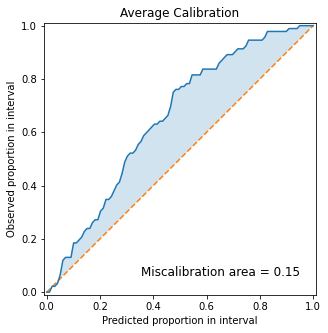

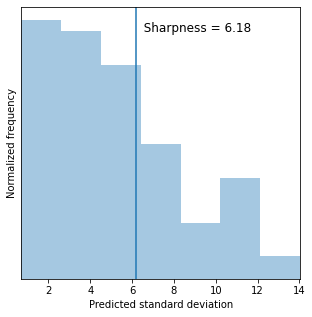

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), var_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), var_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), var_pred.squeeze(1), y)
uviz.plot_sharpness(var_pred.squeeze(1))

Concrete dropout test MAPE:  0.0971169
Concrete dropout test RMSE:  3.0974889
Concrete dropout test NLLK:  3.1038055
Concrete dropout test CRPS:  tensor(1.6251)


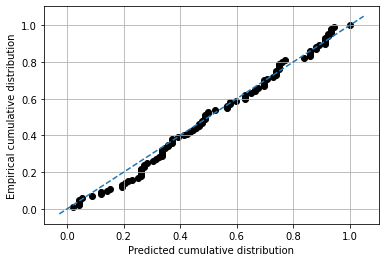

Concrete dropout test calibration error when step size is 0.001:  0.9370340264650281
Concrete dropout test calibration error when step size is 0.01:  0.09538279773156896
Concrete dropout test calibration error when step size is 0.1:  0.009711720226843093


In [7]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [8]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 12.01it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.93it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.237
  RMSE          3.097
  MDAE          1.670
  MARPD         9.588
  R2            0.831
  Correlation   0.916
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.044
  Mean-absolute Calibration Error       0.036
  Miscalibration Area                   0.036
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.207
     Group Size: 0.56 -- Calibration Error: 0.074
     Group Size: 1.00 -- Calibration Error: 0.036
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.230
     Group Size: 0.56 -- Calibration Error: 0.095
     Group Size: 1.00 -- Calibration Error: 0.044
================

Lims is None. Setting lims now:
min_max_true: (11.0, 46.6)
min_max_pred: (13.02151, 43.868652)
lims: (11.0, 46.6)
lims_ext: (7.44000015258789, 50.1599983215332)


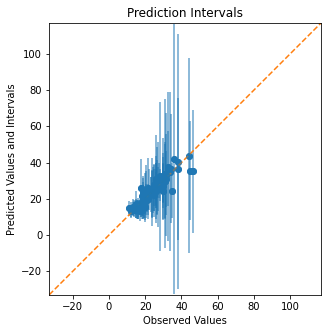

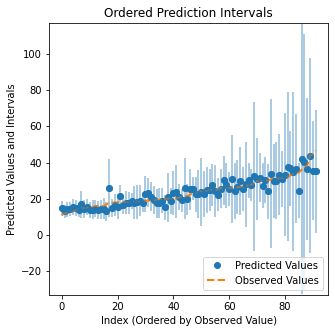

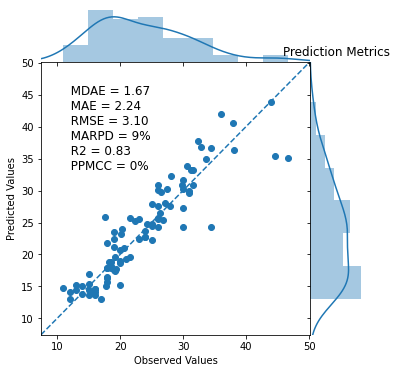

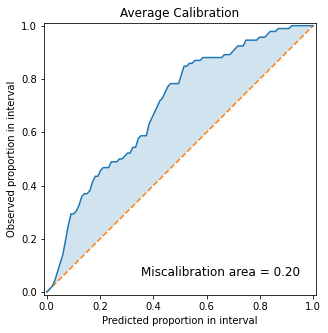

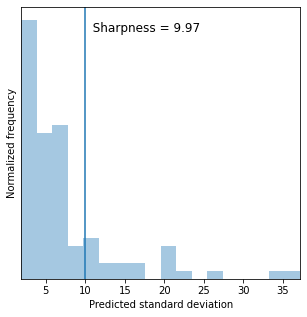

In [9]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), var_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), var_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), var_pred.squeeze(1), y)
uviz.plot_sharpness(var_pred.squeeze(1))